## Step 1: Load libraries and Setup Environment

The system() function will be used to interact with R and manage your workflow. We use mamba to install the necessary bioinformatics packages directly from the R environment.


In [1]:
# Download Miniforge
system("curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh", ignore.stdout = TRUE, ignore.stderr = TRUE)

# Install Miniforge (you can change the path as needed)
system("bash Miniforge3-$(uname)-$(uname -m).sh -b -u -p $HOME/miniforge", ignore.stdout = TRUE, ignore.stderr = TRUE)

# Update PATH to point to the Miniforge bin files
Sys.setenv(PATH = paste0(Sys.getenv("HOME"), "/miniforge/bin:", Sys.getenv("PATH")))

In [2]:
# Use mamba to install the required bioinformatics packages
system("mamba install -y -c conda-forge -c bioconda fastqc multiqc entrez-direct parallel-fastq-dump sra-tools samtools subread HTSeq")

This process can take about 10 minutes to install 

In [3]:
# Install packages if not already installed
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c("DESeq2", "ggplot2", "pheatmap", "apeglm", "ggrepel", "EnhancedVolcano", "ComplexHeatmap", "RColorBrewer"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ggplot2' 'RColorBrewer'”
Installing package(s) 'BiocVersion', 'DESeq2', 'pheatmap', 'apeglm', 'ggrepel',
  'EnhancedVolcano', 'ComplexHeatmap'

also installing the dependencies ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘bdsmatrix’, ‘mvtnorm’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘coda’, ‘bbmle’, ‘rjson’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘ma

In [4]:
# Load libraries
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(apeglm) 
library(ggrepel) 
library(EnhancedVolcano)
library(RColorBrewer)
library(ComplexHeatmap)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [ ]:
# Pull the Docker image
system("docker pull encodedcc/mirna-seq-pipeline:1.2.2")

In [113]:
# Create necessary directories on your host machine (outside Docker)
dir.create("data", recursive = TRUE)
dir.create("data/aligned_bam")
dir.create("data/fastqc")
dir.create("data/fastqc_samples")
dir.create("data/raw_fastq")
dir.create("data/reference")
dir.create("data/sample_STAR")
dir.create("data/star_output")
dir.create("data/trimmed")
dir.create("data/zebrafish_STAR_index")

Warning message in dir.create("data", recursive = TRUE):
“'data' already exists”
Warning message in dir.create("data/aligned_bam"):
“'data/aligned_bam' already exists”
Warning message in dir.create("data/fastqc"):
“'data/fastqc' already exists”
Warning message in dir.create("data/fastqc_samples"):
“'data/fastqc_samples' already exists”
Warning message in dir.create("data/raw_fastq"):
“'data/raw_fastq' already exists”
Warning message in dir.create("data/reference"):
“'data/reference' already exists”
Warning message in dir.create("data/sample_STAR"):
“'data/sample_STAR' already exists”
Warning message in dir.create("data/star_output"):
“'data/star_output' already exists”
Warning message in dir.create("data/trimmed"):
“'data/trimmed' already exists”
Warning message in dir.create("data/zebrafish_STAR_index"):
“'data/zebrafish_STAR_index' already exists”


In [114]:
# Detect number of cores
num_cores <- parallel::detectCores(logical = TRUE)
THREADS <- max(1, num_cores - 1)
print(paste("Number of threads:", THREADS))

[1] "Number of threads: 7"


Executing the SRA Toolkit commands to fetch accession numbers.

In [6]:
system("esearch -db sra -query 'PRJNA300314' | efetch -format runinfo > all_sra_info.txt")
system("grep -E 'GSM1920155|GSM1920156|GSM1920157|GSM1920158|GSM1920159|GSM1920160' all_sra_info.txt | cut -d',' -f1 > accs.txt")
system("cat accs.txt")

## Step 2: Download Data and Reference Files


In [7]:
# Download multiple files using the SRA-Toolkit with parallel threads
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} prefetch {} -O data/raw_fastq -f yes"))

In [8]:
# Download genome and annotation files
system("wget ftp://ftp.ensembl.org/pub/release-104/fasta/danio_rerio/dna/Danio_rerio.GRCz11.dna.primary_assembly.fa.gz -O data/reference/zebrafish_genome.fa.gz")
system("wget -P data/reference/ https://sra-data-athena.s3.amazonaws.com/reference/dre_zebrafish.gtf")
system("wget -P wget -P data/trimmed/ https://sra-data-athena.s3.amazonaws.com/reference/three_prime_adapter_miiR-21-P1-5p.fasta")

# Unzip the genome file
system("gunzip -f data/reference/zebrafish_genome.fa.gz")

## Step 3: Download and Convert SRA to FASTQ

Run the commands inside the Docker container to download and convert SRA files to FASTQ using the prefetch and fasterq-dump tools.

In [9]:
# Convert SRA files to Fastq format using fastq-dump
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} fastq-dump --outdir data/raw_fastq/ --gzip data/raw_fastq/{}/{}.sra"))

## Step 4: Run FastQC

Run FastQC to analyze the quality of the FASTQ files, and then generate a MultiQC report.

In [10]:
# Run FastQC on the downloaded Fastq files
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} fastqc data/raw_fastq/{}.fastq.gz -o data/fastqc/"))

In [11]:
# Run MultiQC to generate a combined QC report
system("multiqc -f data/fastqc/")

# Read and display the MultiQC data using R's data frames
multiqc_data <- read.csv("./multiqc_data/multiqc_fastqc.txt", sep = "\t")
print(multiqc_data)

      Sample            Filename               File.type              Encoding
1 SRR2834933 SRR2834933.fastq.gz Conventional base calls Sanger / Illumina 1.9
2 SRR2834934 SRR2834934.fastq.gz Conventional base calls Sanger / Illumina 1.9
3 SRR2834935 SRR2834935.fastq.gz Conventional base calls Sanger / Illumina 1.9
4 SRR2834936 SRR2834936.fastq.gz Conventional base calls Sanger / Illumina 1.9
5 SRR2834937 SRR2834937.fastq.gz Conventional base calls Sanger / Illumina 1.9
6 SRR2834938 SRR2834938.fastq.gz Conventional base calls Sanger / Illumina 1.9
  Total.Sequences Total.Bases Sequences.flagged.as.poor.quality Sequence.length
1        12350899   617.5 Mbp                                 0              50
2        15081143     754 Mbp                                 0              50
3         5245513   262.2 Mbp                                 0              50
4         8941418     447 Mbp                                 0              50
5         8907800   445.3 Mbp                  

## Step 5: Adapter Trimming using Cutadapt

Trimming the adapter sequences from FASTQ files using cutadapt inside the Docker container.

In [6]:
# Define the list of SRA accessions from your file
accs_ids <- readLines("accs.txt")

# Specify adapter file location
adapter_file <- "data/trimmed/three_prime_adapter_miiR-21-P1-5p.fasta"
trimmed_output_dir <- "data/trimmed"

# Run cutadapt in Docker for each accession
for (i in 1:length(accs_ids)) {
  acc <- accs_ids[i]
  input_fastq <- paste0("data/raw_fastq/", acc, ".fastq.gz")
  trimmed_fastq <- paste0(trimmed_output_dir, "/", acc, "_trimmed.fastq")

  # Run cutadapt inside Docker
  system(paste0(
    "docker run --rm -v ", getwd(), ":/data ",
    "encodedcc/mirna-seq-pipeline:1.2.2 ",
    "cutadapt -a file:/data/", adapter_file, " -e 0.25 -m 15 -M 30 ",
    " --untrimmed-output /data/", trimmed_output_dir, "/", acc, "_untrimmed.fastq",
    " -o /data/", trimmed_output_dir, "/", acc, "_trimmed.fastq",
    " --cores ", THREADS, " /data/", input_fastq
  ))
}

## Step 6: Run Fastqc

In [9]:
# Run FastQC on the downloaded Fastq files
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} fastqc data/trimmed/{}.fastq -o data/fastqc_samples"))

In [10]:
# Run MultiQC to generate a combined QC report
system("multiqc -f data/fastqc_samples/")

# Read and display the MultiQC data using R's data frames
multiqc_data <- read.csv("./multiqc_data/multiqc_fastqc.txt", sep = "\t")
print(multiqc_data)

      Sample            Filename               File.type              Encoding
1 SRR2834933 SRR2834933.fastq.gz Conventional base calls Sanger / Illumina 1.9
2 SRR2834934 SRR2834934.fastq.gz Conventional base calls Sanger / Illumina 1.9
3 SRR2834935 SRR2834935.fastq.gz Conventional base calls Sanger / Illumina 1.9
4 SRR2834936 SRR2834936.fastq.gz Conventional base calls Sanger / Illumina 1.9
5 SRR2834937 SRR2834937.fastq.gz Conventional base calls Sanger / Illumina 1.9
6 SRR2834938 SRR2834938.fastq.gz Conventional base calls Sanger / Illumina 1.9
  Total.Sequences Total.Bases Sequences.flagged.as.poor.quality Sequence.length
1        12350899   617.5 Mbp                                 0              50
2        15081143     754 Mbp                                 0              50
3         5245513   262.2 Mbp                                 0              50
4         8941418     447 Mbp                                 0              50
5         8907800   445.3 Mbp                  

## Step 7: STAR Genome Indexing

Generate a genome index using STAR.

In [9]:
# Define number of threads
THREADS <- 7  # Adjust as necessary


In [11]:
# Create directory for STAR index if it doesn't exist
dir.create(file.path(getwd(), "zebrafish_STAR_index2"), showWarnings = FALSE)


In [24]:
list_data_command <- paste0(
  "docker run --rm -v ", getwd(), ":/data encodedcc/mirna-seq-pipeline:1.2.2 ls /data/data/reference"
)
reference_files <- system(list_data_command, intern = TRUE)
cat(reference_files, sep = "\n")


STAR_index
dre_zebrafish.gtf
dre_zebrafish.gtf.1
dre_zebrafish.gtf.2
dre_zebrafish.gtf.3
zebrafish_genome.fa


In [10]:
# Run STAR genome indexing inside Docker
system(paste0(
  "docker run --rm -v ", getwd(), ":/data ",
      "encodedcc/mirna-seq-pipeline:1.2.2 ",
  "STAR --runThreadN ", THREADS, 
  " --runMode genomeGenerate",
  " --genomeDir /data/data/zebrafish_STAR_index",
  " --genomeFastaFiles /data/data/reference/zebrafish_genome.fa",
  " --sjdbGTFfile /data/data/reference/dre_zebrafish.gtf",
  " --limitGenomeGenerateRAM 29000000000 --sjdbOverhang 1"
))

## Step 8: STAR Genome Alignment

Generate a genome alignment of the trimmed FASTQ files to the genome using STAR.

In [6]:
# Read accession IDs from the file
accs_ids <- readLines("accs.txt")

# Loop through each accession ID
for (i in 1:length(accs_ids)) {
  acc <- accs_ids[i]

  # Construct the command
  system(paste0(
    "docker run --rm -v ", getwd(), ":/data ",
    "encodedcc/mirna-seq-pipeline:1.2.2 ",
    "STAR --genomeDir /data/data/zebrafish_STAR_index ",
    " --readFilesIn /data/data/trimmed/", acc, "_trimmed.fastq ",
    " --sjdbGTFfile /data/data/reference/dre_zebrafish.gtf ",
    " --runThreadN ", THREADS,
    " --alignEndsType EndToEnd ",
    " --outFilterMismatchNmax 1 ",
    " --outFilterMultimapScoreRange 0 ",
    " --quantMode TranscriptomeSAM GeneCounts ",
    " --outReadsUnmapped Fastx ",
    " --outSAMtype BAM SortedByCoordinate ",
    " --outFilterMultimapNmax 10 ",
    " --outSAMunmapped Within ",
    " --outFilterScoreMinOverLread 0 ",
    " --outFilterMatchNminOverLread 0 ",
    " --outFilterMatchNmin 16 ",
    " --alignSJDBoverhangMin 1000 ",
    " --alignIntronMax 1 ",
    " --outWigType wiggle ",
    " --outWigStrand Stranded ",
    " --outWigNorm RPM ",
    "--outFileNamePrefix /data/data/aligned_bam/", acc, "_"
  ))
}

[1] "Processing accession: SRR2834933"
[1] "Processing accession: SRR2834934"
[1] "Processing accession: SRR2834935"
[1] "Processing accession: SRR2834936"
[1] "Processing accession: SRR2834937"
[1] "Processing accession: SRR2834938"


## Step 9: Accessing Results

In [134]:
# Specify the file path
file_path <- "data/aligned_bam/SRR2834934_ReadsPerGene.out.tab"

# Read the file into R
file_data <- read.table(file_path, header = TRUE, skip = 1)

# Print the content to the console
print(file_data)


       N_multimapping X40516 X40516.1 X40516.2
1         N_noFeature  16722    16722    16722
2         N_ambiguous      0        0        0
3  Dre-Mir-723-P2_pre      0        0        0
4    Dre-Mir-2189_pre      0        0        0
5 Dre-Mir-128-P2b_pre      0        0        0


In [20]:
output <- system("featureCounts -a data/reference/dre_zebrafish.gtf -o counts.txt data/aligned_bam/*_Aligned.sortedByCoord.out.bam", intern = TRUE, ignore.stderr = FALSE)
cat(output, sep = "\n")

In [21]:
# Step 1: Read in the count data, treating the first column (Geneid) as row names
count_data <- read.table("counts.txt", header = TRUE, skip = 1, row.names = 1)

# Step 2: Check current column names
cat("Current column names: \n")
print(colnames(count_data))

# Step 3: Rename columns to extract SRR numbers from the file paths
# We'll exclude the first five columns ("Chr", "Start", "End", "Strand", "Length") from renaming
colnames(count_data)[6:ncol(count_data)] <- gsub(".*(SRR[0-9]+).*", "\\1", colnames(count_data)[6:ncol(count_data)])

# Step 4: Check the new column names to ensure they are correct
cat("Updated column names: \n")
print(colnames(count_data))

# Step 5: Add "Geneid" as the header for the row names
colnames(count_data) <- c("Chr", "Start", "End", "Strand", "Length", colnames(count_data)[6:ncol(count_data)])

# Step 6: Write the cleaned count data to a new file with "Geneid" as the first column
write.table(cbind(Geneid = rownames(count_data), count_data), 
            file = "cleaned_counts.txt", 
            sep = "\t", 
            quote = FALSE, 
            row.names = FALSE)


Current column names: 
 [1] "Chr"                                                      
 [2] "Start"                                                    
 [3] "End"                                                      
 [4] "Strand"                                                   
 [5] "Length"                                                   
 [6] "data.aligned_bam.SRR2834933_Aligned.sortedByCoord.out.bam"
 [7] "data.aligned_bam.SRR2834934_Aligned.sortedByCoord.out.bam"
 [8] "data.aligned_bam.SRR2834935_Aligned.sortedByCoord.out.bam"
 [9] "data.aligned_bam.SRR2834936_Aligned.sortedByCoord.out.bam"
[10] "data.aligned_bam.SRR2834937_Aligned.sortedByCoord.out.bam"
[11] "data.aligned_bam.SRR2834938_Aligned.sortedByCoord.out.bam"
Updated column names: 
 [1] "Chr"        "Start"      "End"        "Strand"     "Length"    
 [6] "SRR2834933" "SRR2834934" "SRR2834935" "SRR2834936" "SRR2834937"
[11] "SRR2834938"


In [22]:
# Load necessary library
library(DESeq2)

# Read in the count data
count_data <- read.table("cleaned_counts.txt", header = TRUE, row.names = 1)

# Confirm dimensions
dim(count_data)  # Should show 36211 rows and 6 columns

# Create col_data with the correct number of conditions
col_data <- data.frame(condition = c("0dpa", "0dpa", "0dpa", "4dpa", "4dpa", "4dpa"))  # Adjust according to your experimental design

# Confirm dimensions of col_data
dim(col_data)    # Should show 6 rows to match count_data

# Check column names to ensure they match
colnames(count_data)

# Create DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = count_data[, -c(1:5)], colData = col_data, design = ~ condition)  # Exclude the annotation columns

# Run the DESeq analysis
dds <- DESeq(dds)

# Get results
results <- results(dds)

# Summary of results
summary(results)


[1] 362  11

[1] 6 1

[1] "Chr"        "Start"      "End"        "Strand"     "Length"    
 [6] "SRR2834933" "SRR2834934" "SRR2834935" "SRR2834936" "SRR2834937"
[11] "SRR2834938"

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 32 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [23]:
head(count_data)  # View the first few lines of count data


,Chr,Start,End,Strand,Length,SRR2834933,SRR2834934,SRR2834935,SRR2834936,SRR2834937,SRR2834938
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Dre-Mir-155_pre,chr1,576454,576513,+,60,0,0,0,0,0,0
Dre-Mir-459_pre,chr1,1575493,1575555,+,63,0,0,0,0,0,0
Dre-Mir-92-P1a1_pre,chr1,3297377,3297435,-,59,1,0,0,0,0,0
Dre-Mir-19-P2a1_pre,chr1,3297494,3297555,-,62,0,0,0,0,0,0
Dre-Mir-17-P4a1_pre,chr1,3297646,3297705,-,60,0,0,0,0,0,0
Dre-Mir-19-P1a1_pre,chr1,3297862,3297919,-,58,0,0,0,0,0,0


using ntop=500 top features by variance



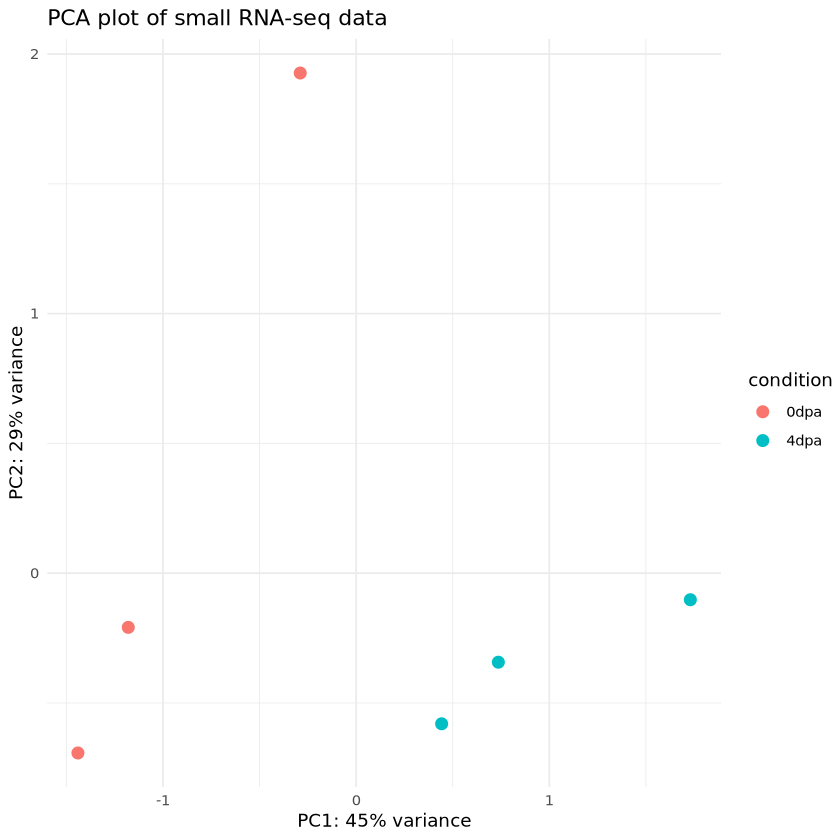

In [24]:
# Use varianceStabilizingTransformation directly
vsd <- varianceStabilizingTransformation(dds, blind = FALSE)

# Perform PCA on the transformed data and plot the first two principal components
pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

# Create a PCA plot using ggplot2
ggplot(pcaData, aes(PC1, PC2, color = condition)) +
  geom_point(size = 3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal() +
  ggtitle("PCA plot of small RNA-seq data")


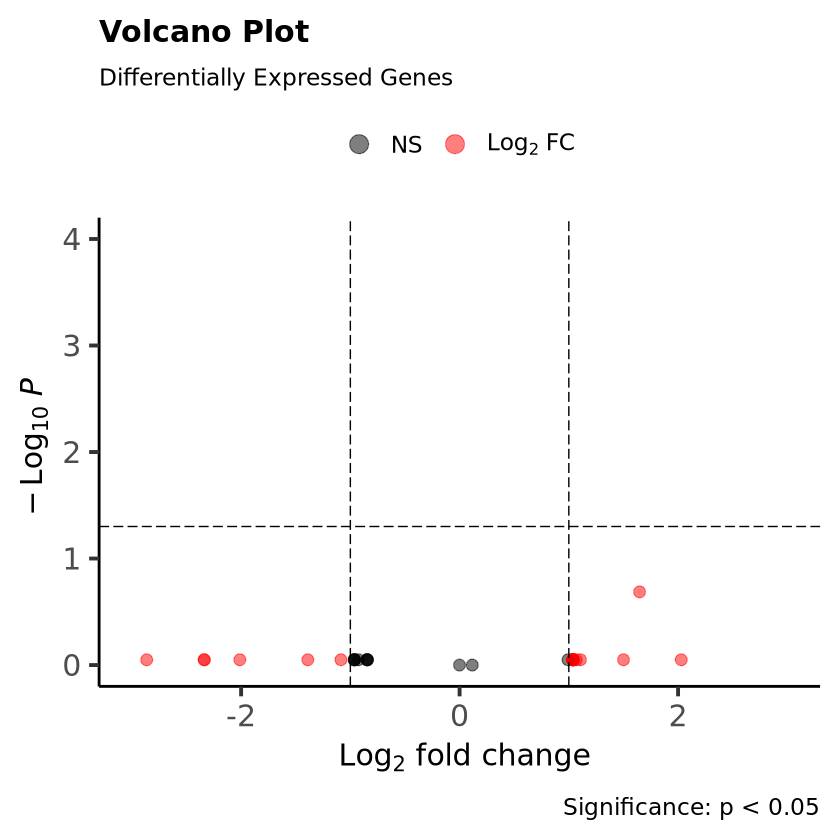

In [25]:
# Convert results to a data frame for EnhancedVolcano
res_df <- as.data.frame(results)
res_df$gene <- rownames(res_df)  # Add gene names as a column if needed

# Create the volcano plot
EnhancedVolcano(res_df,
  lab = res_df$gene,                 # Labels for the points (gene names)
  x = 'log2FoldChange',              # Column for log2 fold change
  y = 'padj',                        # Column for adjusted p-values
  xlim = c(-3, 3),                   # X-axis limits
  ylim = c(0, -log10(0.0001)),       # Y-axis limits; adjust according to your p-value range
  pCutoff = 0.05,                    # Cutoff for significance
  FCcutoff = 1,                      # Fold change cutoff
  pointSize = 3.0,                   # Size of the points
  labSize = 4.0,                     # Size of the labels
  col = c("black", "red"),           # Colors for points
  title = 'Volcano Plot',            # Title of the plot
  subtitle = 'Differentially Expressed Genes', # Subtitle
  caption = 'Significance: p < 0.05',           # Caption
  gridlines.major = FALSE,           # Remove major gridlines
  gridlines.minor = FALSE             # Remove minor gridlines
)


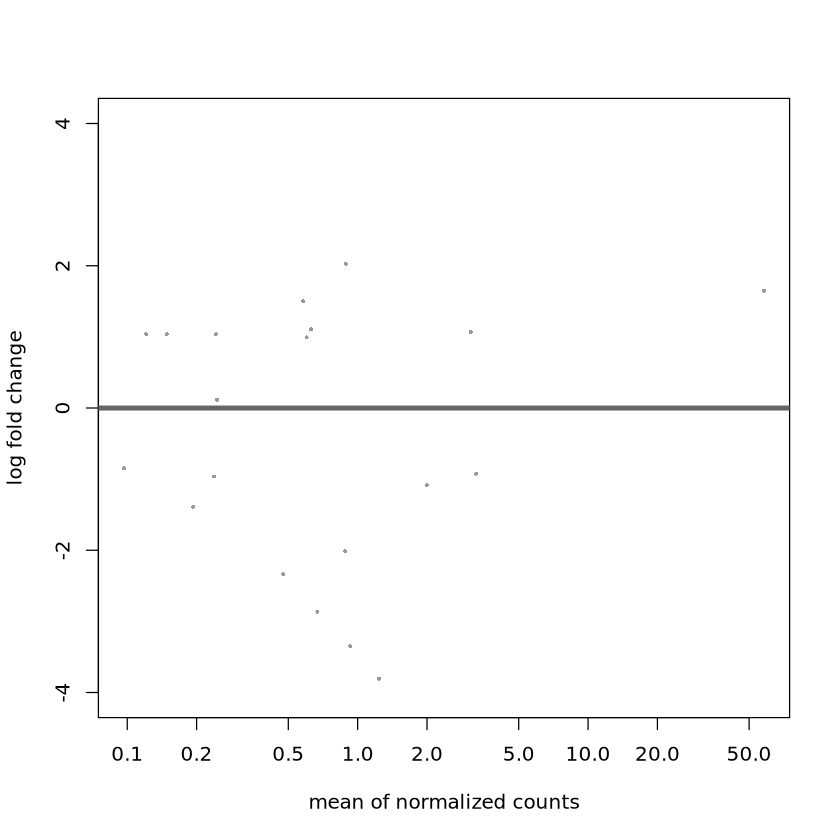

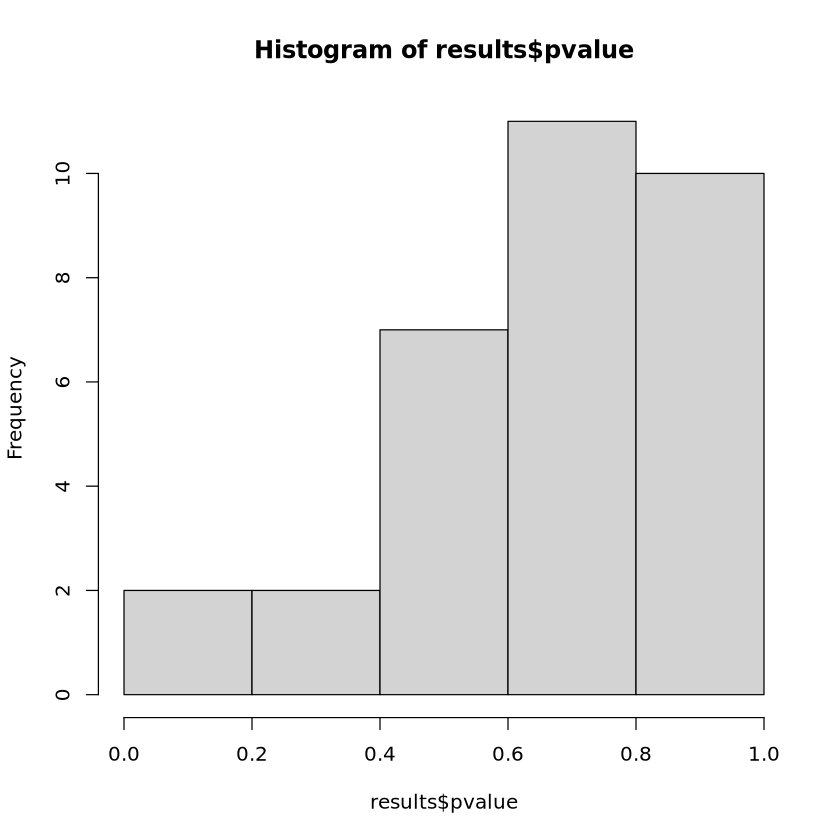

In [26]:
# MA plot to visualize results
plotMA(results)  
hist(results$pvalue)  
